In [1]:
PATH = '/Users/siddhantthakur/pizza req/'

from tqdm import tqdm
import json
import pandas as pd
import numpy as np
from statistics import mean
from prettytable import PrettyTable

import matplotlib.pyplot as plt
import shap

import nltk
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import warnings
warnings.filterwarnings("ignore")

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

np.set_printoptions(suppress=True)

RANDOM_STATE = 4

In [2]:
# certificate verification fail

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siddhantthakur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/siddhantthakur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/siddhantthakur/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
with open(PATH + 'pizza_request_dataset/pizza_request_dataset.json', 'r') as f:
    data = json.load(f)

In [5]:
len(data)

5671

In [6]:
sorted(data[0].keys())

['giver_username_if_known',
 'in_test_set',
 'number_of_downvotes_of_request_at_retrieval',
 'number_of_upvotes_of_request_at_retrieval',
 'post_was_edited',
 'request_id',
 'request_number_of_comments_at_retrieval',
 'request_text',
 'request_text_edit_aware',
 'request_title',
 'requester_account_age_in_days_at_request',
 'requester_account_age_in_days_at_retrieval',
 'requester_days_since_first_post_on_raop_at_request',
 'requester_days_since_first_post_on_raop_at_retrieval',
 'requester_number_of_comments_at_request',
 'requester_number_of_comments_at_retrieval',
 'requester_number_of_comments_in_raop_at_request',
 'requester_number_of_comments_in_raop_at_retrieval',
 'requester_number_of_posts_at_request',
 'requester_number_of_posts_at_retrieval',
 'requester_number_of_posts_on_raop_at_request',
 'requester_number_of_posts_on_raop_at_retrieval',
 'requester_number_of_subreddits_at_request',
 'requester_received_pizza',
 'requester_subreddits_at_request',
 'requester_upvotes_minus

In [7]:
success = [d['requester_received_pizza'] for d in data]
print("Average Success Rate",str(sum(success)/len(success)*100))

Average Success Rate 24.634103332745546


In [8]:
for d in data:
    d['upvotes_minus_downvotes'] = d['number_of_upvotes_of_request_at_retrieval'] - d['number_of_downvotes_of_request_at_retrieval']

for d in data:
    d['final_request_text'] = d['request_title'] + " " + d['request_text_edit_aware']

In [9]:
data[0]

{'giver_username_if_known': 'N/A',
 'in_test_set': False,
 'number_of_downvotes_of_request_at_retrieval': 2,
 'number_of_upvotes_of_request_at_retrieval': 6,
 'post_was_edited': False,
 'request_id': 't3_w5491',
 'request_number_of_comments_at_retrieval': 7,
 'request_text': "I'm not in College, or a starving artist or anything like that. I've just been a bit unlucky lately. I'm a 36 year old single guy with a job. But rent, and other bills killed me this month. I thought I had enough funds in my account to at least keep me set with Mr. Noodles, I forgot about my monthly banking fee.\n\nI had a small bag of chips Wednesday afternoon, and I get paid Monday, so I'll be fine then.. It's just really painful at this point and food is something I'm constantly thinking about.\n\nI've got a few bucks to get on the bus to work on Saturday, so I can't really use that.\n\nI'm really embarrassed to even be asking like this and I'm not sure how it works, so please be patient with me.\n\nI guess tha

In [10]:
df = pd.json_normalize(data)
df['requester_received_pizza'] = df['requester_received_pizza'].astype(int)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,giver_username_if_known,in_test_set,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,...,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,upvotes_minus_downvotes,final_request_text
0,pizzaman2012,True,5,5,False,t3_10u1pr,2,I am a recently seperated mother of two wonder...,I am a recently seperated mother of two wonder...,"[REQUEST] Ohio, Begging for my kids sake, humb...",...,0,24,0,62,shroom,allaside,1.349212e+09,1.349209e+09,0,"[REQUEST] Ohio, Begging for my kids sake, humb..."
1,N/A,False,1,3,False,t3_revjv,0,Hey Reddit. I've never had to do this before ...,Hey Reddit. I've never had to do this before ...,[REQUEST] First time I've been broke in years,...,0,6,0,12,None,tooembarassedplshelp,1.332804e+09,1.332800e+09,2,[REQUEST] First time I've been broke in years ...
2,N/A,True,3,5,False,t3_ibsyq,23,"I feel weird asking, but my family would reall...","I feel weird asking, but my family would reall...",request joplin mo,...,0,13,0,21,None,tigers12,1.309310e+09,1.309306e+09,2,"request joplin mo I feel weird asking, but my ..."
3,N/A,False,0,1,False,t3_u2x1g,1,Could really go for some cheesy goodness to co...,Could really go for some cheesy goodness to co...,"[REQUEST] Florida, USA. Just finished correspo...",...,1166,2235,2410,4545,None,vampyromorph,1.337879e+09,1.337876e+09,1,"[REQUEST] Florida, USA. Just finished correspo..."
4,N/A,False,0,1,False,t3_pvhrc,0,I'm a hungry student and would love a meal tha...,I'm a hungry student and would love a meal tha...,"[Request] Hungry Student , Oxford, UK",...,1,4,1,4,None,emmo245,1.329592e+09,1.329592e+09,1,"[Request] Hungry Student , Oxford, UK I'm a hu..."


In [11]:
df['requester_received_pizza'].isna().sum()

0

In [12]:
# text preprocessing
stopwords_eng = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def process_text(text):
    text = text.replace("\n"," ").replace("\r"," ")
    text = re.sub(r'“', " '' ", text)
    text = re.sub(r'”', " '' ", text)
    text = re.sub(r'"', " '' ", text)
    text = re.sub(r'(\S)(\'\')', r'\1 \2 ', text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    punc_list = '!"#$%()*+,-./:;<=>?@^_{|}~[]'
    t = str.maketrans(dict.fromkeys(punc_list," "))
    text = text.translate(t)
    
    t = str.maketrans(dict.fromkeys("'`",""))
    text = text.translate(t)
    
    text = text.lower()
    
    tokens = regexp_tokenize(text,pattern='\s+',gaps=True)
    cleaned_tokens = []
    
    for t in tokens:
        if t not in stopwords_eng:
            l = lemmatizer.lemmatize(t)
            cleaned_tokens.append(l)
    
    return cleaned_tokens

In [13]:
df['final_request_text'][0]

"[REQUEST] Ohio, Begging for my kids sake, humbly asking for my sake I am a recently seperated mother of two wonderful kids. My husband walked out on us for someone else and left us high and dry. I have been a homemaker for 10 years. I'm actively looking for work and awaiting foodstamp benefits. It would be fantastic if a gracious redditor could randomly pick us for dinner tonight. My account is brand new but I guess everyone has to start somewhere."

In [14]:
process_text(df['final_request_text'][0])

['request',
 'ohio',
 'begging',
 'kid',
 'sake',
 'humbly',
 'asking',
 'sake',
 'recently',
 'seperated',
 'mother',
 'two',
 'wonderful',
 'kid',
 'husband',
 'walked',
 'u',
 'someone',
 'else',
 'left',
 'u',
 'high',
 'dry',
 'homemaker',
 '10',
 'year',
 'actively',
 'looking',
 'work',
 'awaiting',
 'foodstamp',
 'benefit',
 'would',
 'fantastic',
 'gracious',
 'redditor',
 'could',
 'randomly',
 'pick',
 'u',
 'dinner',
 'tonight',
 'account',
 'brand',
 'new',
 'guess',
 'everyone',
 'start',
 'somewhere']

In [15]:
# 20% split for train and test data
train_set = df.loc[:4536,:]
test_set = df.loc[4537:,:].reset_index(drop=True)
print(train_set.shape)
print(test_set.shape)

(4537, 35)
(1134, 35)


In [16]:
final_df = df.loc[:,['upvotes_minus_downvotes','requester_account_age_in_days_at_request','request_number_of_comments_at_retrieval']]
final_df['length_of_text'] = df.apply(lambda r: len(r['final_request_text']), axis = 1)
final_df['evidence_link'] = df.apply(lambda r: 1 if re.findall(r'(?:http\:|https\:)?\/\/.*\.',r['final_request_text']) else 0, axis = 1)
final_df['requester_posted_before'] = df.apply(lambda r: 0 if r['requester_days_since_first_post_on_raop_at_request']==0 else 1, axis = 1)
final_df['requester_received_pizza'] = df.loc[:,'requester_received_pizza']

final_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,requester_posted_before,requester_received_pizza
0,0,0.000000,2,452,0,0,1
1,2,0.000000,0,623,0,0,0
2,2,0.000000,23,423,0,0,0
3,1,326.575567,1,209,1,0,0
4,1,0.000000,0,144,0,0,0
...,...,...,...,...,...,...,...
5666,4,4.233056,0,134,0,0,0
5667,1,3.019410,0,545,0,0,0
5668,5,505.021308,0,235,0,0,0
5669,2,319.033148,0,242,0,0,0


In [17]:
final_train_set = final_df.loc[:4536,:]
final_test_set = final_df.loc[4537:,:].reset_index(drop=True)
print(final_train_set.shape)
print(final_test_set.shape)

(4537, 7)
(1134, 7)


## Random Forest based Count Model

In [18]:
new_count_vec = CountVectorizer(analyzer=process_text, max_features=12500)
new_count_df = new_count_vec.fit_transform(train_set['final_request_text'])
new_count_labels = train_set['requester_received_pizza']

print(new_count_df.shape)

(4537, 12500)


In [19]:
# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_tfidf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=RANDOM_STATE)
new_count_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_count_model_nbg = GaussianNB()
new_count_model_nbm = MultinomialNB()
new_count_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_count_model_lr_accuracy_score = []
new_count_model_nbg_accuracy_score = []
new_count_model_nbm_accuracy_score = []
new_count_model_rf_accuracy_score = []


for train_index, test_index in new_skfold_tfidf.split(new_count_df, new_count_labels):
    X_train, X_test = new_count_df[train_index], new_count_df[test_index]
    y_train, y_test = new_count_labels[train_index], new_count_labels[test_index]
    
    new_count_model_lr.fit(X_train,y_train)
    new_count_model_lr_accuracy_score.append(accuracy_score(y_test,new_count_model_lr.predict(X_test)))

    new_count_model_nbg.fit(X_train.toarray(),y_train)
    new_count_model_nbg_accuracy_score.append(accuracy_score(y_test,new_count_model_nbg.predict(X_test.toarray())))
    
    new_count_model_nbm.fit(X_train,y_train)
    new_count_model_nbm_accuracy_score.append(accuracy_score(y_test,new_count_model_nbm.predict(X_test)))
    
    new_count_model_rf.fit(X_train,y_train)
    new_count_model_rf_accuracy_score.append(accuracy_score(y_test,new_count_model_rf.predict(X_test)))

new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy']
new_t.add_rows([
    ['Logistic Regression', mean(new_count_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_count_model_nbg_accuracy_score)],
    ['Multinomial NB', mean(new_count_model_nbm_accuracy_score)],
    ['Random Forest', mean(new_count_model_rf_accuracy_score)],
])
new_t

Model,Accuracy
Logistic Regression,0.6162670176648583
Gaussian NB,0.5164212269718149
Multinomial NB,0.7114838578068765
Random Forest,0.7474102550403372


In [20]:
new_final_count_rf_df = final_train_set.copy()
new_count_rf_est_prob = new_count_model_rf.predict_proba(new_count_df)[:,1]
new_final_count_rf_df.insert(5,'prob_from_text',new_count_rf_est_prob)
new_final_count_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,0,0.000000,2,452,0,0.484621,0,1
1,2,0.000000,0,623,0,0.214940,0,0
2,2,0.000000,23,423,0,0.218061,0,0
3,1,326.575567,1,209,1,0.212692,0,0
4,1,0.000000,0,144,0,0.163295,0,0
...,...,...,...,...,...,...,...,...
4532,4,800.729537,4,171,1,0.159045,0,0
4533,1,995.245914,1,597,0,0.511370,1,1
4534,-1,366.443414,0,273,0,0.335595,0,1
4535,1,0.000000,2,555,1,0.237383,0,0


In [21]:
new_final_count_rf_df = new_final_count_rf_df.sample(frac=1).reset_index(drop=True)
new_final_count_rf_labels = new_final_count_rf_df.iloc[:,-1]
new_final_count_rf_df = new_final_count_rf_df.iloc[:,:-1]
new_final_count_rf_labels

0       0
1       0
2       0
3       0
4       1
       ..
4532    1
4533    0
4534    0
4535    1
4536    0
Name: requester_received_pizza, Length: 4537, dtype: int64

In [22]:
new_skfold_final_count_rf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=RANDOM_STATE)
new_final_count_rf_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_final_count_rf_model_nbg = GaussianNB()
new_final_count_rf_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_final_count_rf_model_lr_accuracy_score = []
new_final_count_rf_model_nbg_accuracy_score = []
new_final_count_rf_model_rf_accuracy_score = []

new_final_count_rf_model_lr_precision_score = []
new_final_count_rf_model_nbg_precision_score = []
new_final_count_rf_model_rf_precision_score = []

new_final_count_rf_model_lr_recall_score = []
new_final_count_rf_model_nbg_recall_score = []
new_final_count_rf_model_rf_recall_score = []

new_final_count_rf_model_lr_f1_score = []
new_final_count_rf_model_nbg_f1_score = []
new_final_count_rf_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_count_rf.split(new_final_count_rf_df, new_final_count_rf_labels):
    X_train, X_test = new_final_count_rf_df.iloc[train_index,:], new_final_count_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_count_rf_labels[train_index], new_final_count_rf_labels[test_index]
    
    new_final_count_rf_model_lr.fit(X_train,y_train)
    new_final_count_rf_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_count_rf_model_lr.predict(X_test)))
    new_final_count_rf_model_lr_precision_score.append(precision_score(y_test,new_final_count_rf_model_lr.predict(X_test)))
    new_final_count_rf_model_lr_recall_score.append(recall_score(y_test,new_final_count_rf_model_lr.predict(X_test)))
    new_final_count_rf_model_lr_f1_score.append(f1_score(y_test,new_final_count_rf_model_lr.predict(X_test)))
    
    new_final_count_rf_model_nbg.fit(X_train,y_train)
    new_final_count_rf_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_count_rf_model_nbg.predict(X_test)))
    new_final_count_rf_model_nbg_precision_score.append(precision_score(y_test,new_final_count_rf_model_nbg.predict(X_test)))
    new_final_count_rf_model_nbg_recall_score.append(recall_score(y_test,new_final_count_rf_model_nbg.predict(X_test)))
    new_final_count_rf_model_nbg_f1_score.append(f1_score(y_test,new_final_count_rf_model_nbg.predict(X_test)))
    
    new_final_count_rf_model_rf.fit(X_train,y_train)
    new_final_count_rf_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_count_rf_model_rf.predict(X_test)))
    new_final_count_rf_model_rf_precision_score.append(precision_score(y_test,new_final_count_rf_model_rf.predict(X_test)))
    new_final_count_rf_model_rf_recall_score.append(recall_score(y_test,new_final_count_rf_model_rf.predict(X_test)))
    new_final_count_rf_model_rf_f1_score.append(f1_score(y_test,new_final_count_rf_model_rf.predict(X_test)))

new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', mean(new_final_count_rf_model_lr_accuracy_score),mean(new_final_count_rf_model_lr_precision_score),mean(new_final_count_rf_model_lr_recall_score),mean(new_final_count_rf_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_count_rf_model_nbg_accuracy_score),mean(new_final_count_rf_model_nbg_precision_score),mean(new_final_count_rf_model_nbg_recall_score),mean(new_final_count_rf_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_count_rf_model_rf_accuracy_score),mean(new_final_count_rf_model_rf_precision_score),mean(new_final_count_rf_model_rf_recall_score),mean(new_final_count_rf_model_rf_f1_score)],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.8417353525443322,0.6366565792306439,0.8882096069868995,0.7406329611613652
Gaussian NB,0.8931018655683403,0.8002977982787708,0.7703056768558952,0.7846002232103999
Random Forest,0.9365211351747786,0.9088975127323685,0.8323144104803494,0.8688010784395689


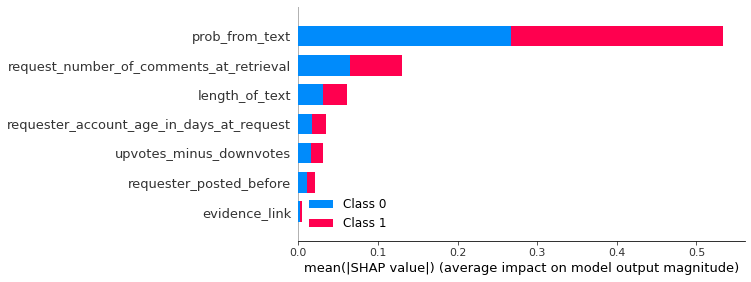

In [23]:
# using shapley values to understand importance of each feature
count_explainer = shap.TreeExplainer(new_final_count_rf_model_rf)
count_shap_values = count_explainer.shap_values(X_test)
shap.summary_plot(count_shap_values, X_test, plot_type="bar")
#plt.savefig('eps/FeatureImportanceShapley_count.eps',dpi=1200,bbox_inches='tight')

<BarContainer object of 7 artists>

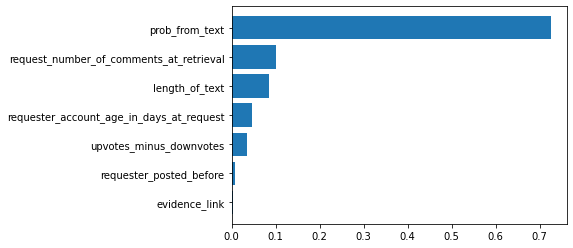

In [24]:
sorted_idx = new_final_count_rf_model_rf.feature_importances_.argsort()
plt.barh(new_final_count_rf_df.columns[sorted_idx], new_final_count_rf_model_rf.feature_importances_[sorted_idx])

In [25]:
test_count_df = new_count_vec.transform(test_set['final_request_text'])
print(test_count_df.shape)

(1134, 12500)


In [26]:
test_final_count_rf_df = final_test_set.copy()
test_count_rf_est_prob = new_count_model_rf.predict_proba(test_count_df)[:,1]
test_final_count_rf_df.insert(5,'prob_from_text',test_count_rf_est_prob)
test_final_count_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,32,101.674711,7,544,0,0.222404,0,0
1,0,375.440579,0,418,0,0.259395,1,1
2,4,256.866597,2,284,0,0.213448,0,0
3,-1,658.583252,0,508,0,0.186247,0,0
4,7,107.608137,9,1234,0,0.391967,0,1
...,...,...,...,...,...,...,...,...
1129,4,4.233056,0,134,0,0.148276,0,0
1130,1,3.019410,0,545,0,0.278656,0,0
1131,5,505.021308,0,235,0,0.156639,0,0
1132,2,319.033148,0,242,0,0.183351,0,0


In [27]:
test_final_count_rf_df = test_final_count_rf_df.sample(frac=1).reset_index(drop=True)
test_final_count_rf_labels = test_final_count_rf_df.iloc[:,-1]
test_final_count_rf_df = test_final_count_rf_df.iloc[:,:-1]
test_final_count_rf_labels

0       1
1       1
2       0
3       0
4       0
       ..
1129    0
1130    0
1131    0
1132    1
1133    1
Name: requester_received_pizza, Length: 1134, dtype: int64

In [28]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)), precision_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)), recall_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)), f1_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)), precision_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)), recall_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)), f1_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df))],
    ['Random Forest', accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df)), precision_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df)), recall_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df)), f1_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.6552028218694885,0.3309002433090024,0.5396825396825397,0.41025641025641024
Gaussian NB,0.7266313932980599,0.36818181818181817,0.32142857142857145,0.3432203389830509
Random Forest,0.7627865961199295,0.44516129032258067,0.27380952380952384,0.3390663390663391


## Random Forest based TF-IDF Model

In [29]:
new_tfidf_vec = TfidfVectorizer(analyzer=process_text, max_features = 12500)
new_tfidf_df = new_tfidf_vec.fit_transform(train_set['final_request_text'])

new_tfidf_labels = train_set['requester_received_pizza']

print(new_tfidf_df.shape)

(4537, 12500)


In [30]:
# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_tfidf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=RANDOM_STATE)
new_tfidf_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_tfidf_model_nbg = GaussianNB()
new_tfidf_model_nbm = MultinomialNB()
new_tfidf_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_tfidf_model_lr_accuracy_score = []
new_tfidf_model_nbg_accuracy_score = []
new_tfidf_model_nbm_accuracy_score = []
new_tfidf_model_rf_accuracy_score = []


for train_index, test_index in new_skfold_tfidf.split(new_tfidf_df, new_tfidf_labels):
    X_train, X_test = new_tfidf_df[train_index], new_tfidf_df[test_index]
    y_train, y_test = new_tfidf_labels[train_index], new_tfidf_labels[test_index]
    
    new_tfidf_model_lr.fit(X_train,y_train)
    new_tfidf_model_lr_accuracy_score.append(accuracy_score(y_test,new_tfidf_model_lr.predict(X_test)))

    new_tfidf_model_nbg.fit(X_train.toarray(),y_train)
    new_tfidf_model_nbg_accuracy_score.append(accuracy_score(y_test,new_tfidf_model_nbg.predict(X_test.toarray())))
    
    new_tfidf_model_nbm.fit(X_train,y_train)
    new_tfidf_model_nbm_accuracy_score.append(accuracy_score(y_test,new_tfidf_model_nbm.predict(X_test)))
    
    new_tfidf_model_rf.fit(X_train,y_train)
    new_tfidf_model_rf_accuracy_score.append(accuracy_score(y_test,new_tfidf_model_rf.predict(X_test)))

new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy']
new_t.add_rows([
    ['Logistic Regression', mean(new_tfidf_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_tfidf_model_nbg_accuracy_score)],
    ['Multinomial NB', mean(new_tfidf_model_nbm_accuracy_score)],
    ['Random Forest', mean(new_tfidf_model_rf_accuracy_score)],
])
new_t

Model,Accuracy
Logistic Regression,0.5505879381608537
Gaussian NB,0.5208294275070547
Multinomial NB,0.7476305193575179
Random Forest,0.7474102550403372


In [31]:
new_final_tfidf_rf_df = final_train_set.copy()
new_tfidf_rf_est_prob = new_tfidf_model_rf.predict_proba(new_tfidf_df)[:,1]
new_final_tfidf_rf_df.insert(5,'prob_from_text',new_tfidf_rf_est_prob)
new_final_tfidf_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,0,0.000000,2,452,0,0.564798,0,1
1,2,0.000000,0,623,0,0.179958,0,0
2,2,0.000000,23,423,0,0.178260,0,0
3,1,326.575567,1,209,1,0.234761,0,0
4,1,0.000000,0,144,0,0.150267,0,0
...,...,...,...,...,...,...,...,...
4532,4,800.729537,4,171,1,0.151110,0,0
4533,1,995.245914,1,597,0,0.560565,1,1
4534,-1,366.443414,0,273,0,0.479423,0,1
4535,1,0.000000,2,555,1,0.146777,0,0


In [32]:
new_final_tfidf_rf_df = new_final_tfidf_rf_df.sample(frac=1).reset_index(drop=True)
new_final_tfidf_rf_labels = new_final_tfidf_rf_df.iloc[:,-1]
new_final_tfidf_rf_df = new_final_tfidf_rf_df.iloc[:,:-1]
new_final_tfidf_rf_labels

0       1
1       1
2       0
3       0
4       0
       ..
4532    0
4533    0
4534    0
4535    1
4536    0
Name: requester_received_pizza, Length: 4537, dtype: int64

In [33]:
new_skfold_final_tfidf_rf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=RANDOM_STATE)
new_final_tfidf_rf_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_final_tfidf_rf_model_nbg = GaussianNB()
new_final_tfidf_rf_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_final_tfidf_rf_model_lr_accuracy_score = []
new_final_tfidf_rf_model_nbg_accuracy_score = []
new_final_tfidf_rf_model_rf_accuracy_score = []

new_final_tfidf_rf_model_lr_precision_score = []
new_final_tfidf_rf_model_nbg_precision_score = []
new_final_tfidf_rf_model_rf_precision_score = []

new_final_tfidf_rf_model_lr_recall_score = []
new_final_tfidf_rf_model_nbg_recall_score = []
new_final_tfidf_rf_model_rf_recall_score = []

new_final_tfidf_rf_model_lr_f1_score = []
new_final_tfidf_rf_model_nbg_f1_score = []
new_final_tfidf_rf_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_tfidf_rf.split(new_final_tfidf_rf_df, new_final_tfidf_rf_labels):
    X_train, X_test = new_final_tfidf_rf_df.iloc[train_index,:], new_final_tfidf_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_tfidf_rf_labels[train_index], new_final_tfidf_rf_labels[test_index]
    
    new_final_tfidf_rf_model_lr.fit(X_train,y_train)
    new_final_tfidf_rf_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_tfidf_rf_model_lr.predict(X_test)))
    new_final_tfidf_rf_model_lr_precision_score.append(precision_score(y_test,new_final_tfidf_rf_model_lr.predict(X_test)))
    new_final_tfidf_rf_model_lr_recall_score.append(recall_score(y_test,new_final_tfidf_rf_model_lr.predict(X_test)))
    new_final_tfidf_rf_model_lr_f1_score.append(f1_score(y_test,new_final_tfidf_rf_model_lr.predict(X_test)))
    
    new_final_tfidf_rf_model_nbg.fit(X_train,y_train)
    new_final_tfidf_rf_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_tfidf_rf_model_nbg.predict(X_test)))
    new_final_tfidf_rf_model_nbg_precision_score.append(precision_score(y_test,new_final_tfidf_rf_model_nbg.predict(X_test)))
    new_final_tfidf_rf_model_nbg_recall_score.append(recall_score(y_test,new_final_tfidf_rf_model_nbg.predict(X_test)))
    new_final_tfidf_rf_model_nbg_f1_score.append(f1_score(y_test,new_final_tfidf_rf_model_nbg.predict(X_test)))
    
    new_final_tfidf_rf_model_rf.fit(X_train,y_train)
    new_final_tfidf_rf_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_tfidf_rf_model_rf.predict(X_test)))
    new_final_tfidf_rf_model_rf_precision_score.append(precision_score(y_test,new_final_tfidf_rf_model_rf.predict(X_test)))
    new_final_tfidf_rf_model_rf_recall_score.append(recall_score(y_test,new_final_tfidf_rf_model_rf.predict(X_test)))
    new_final_tfidf_rf_model_rf_f1_score.append(f1_score(y_test,new_final_tfidf_rf_model_rf.predict(X_test)))

new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', mean(new_final_tfidf_rf_model_lr_accuracy_score),mean(new_final_tfidf_rf_model_lr_precision_score),mean(new_final_tfidf_rf_model_lr_recall_score),mean(new_final_tfidf_rf_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_tfidf_rf_model_nbg_accuracy_score),mean(new_final_tfidf_rf_model_nbg_precision_score),mean(new_final_tfidf_rf_model_nbg_recall_score),mean(new_final_tfidf_rf_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_tfidf_rf_model_rf_accuracy_score),mean(new_final_tfidf_rf_model_rf_precision_score),mean(new_final_tfidf_rf_model_rf_recall_score),mean(new_final_tfidf_rf_model_rf_f1_score)],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.8917717799396763,0.7293498465380219,0.9187772925764192,0.8122681490530927
Gaussian NB,0.9162412756388151,0.8305641163711177,0.8393013100436681,0.8347450762043569
Random Forest,0.9407056715026058,0.9171387785329552,0.8410480349344979,0.8773196275905059


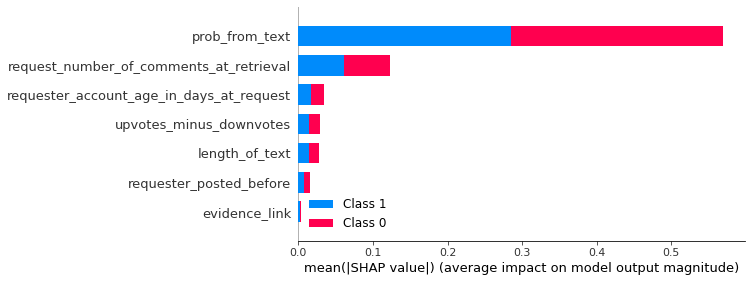

In [34]:
# using shapley values to understand importance of each feature
tfidf_explainer = shap.TreeExplainer(new_final_tfidf_rf_model_rf)
tfidf_shap_values = tfidf_explainer.shap_values(X_test)
shap.summary_plot(tfidf_shap_values, X_test, plot_type="bar")
#plt.savefig('eps/FeatureImportanceShapley_rf.eps',dpi=1200,bbox_inches='tight')

<BarContainer object of 7 artists>

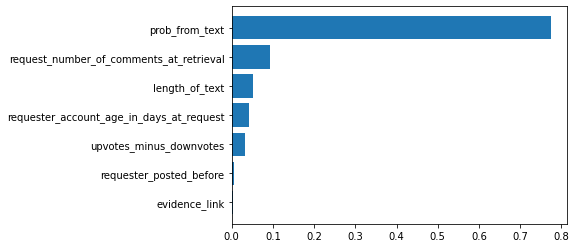

In [35]:
sorted_idx = new_final_tfidf_rf_model_rf.feature_importances_.argsort()
plt.barh(new_final_tfidf_rf_df.columns[sorted_idx], new_final_tfidf_rf_model_rf.feature_importances_[sorted_idx])

In [36]:
test_tfidf_df = new_tfidf_vec.transform(test_set['final_request_text'])
print(test_tfidf_df.shape)

(1134, 12500)


In [37]:
final_test_set

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,requester_posted_before,requester_received_pizza
0,32,101.674711,7,544,0,0,0
1,0,375.440579,0,418,0,1,1
2,4,256.866597,2,284,0,0,0
3,-1,658.583252,0,508,0,0,0
4,7,107.608137,9,1234,0,0,1
...,...,...,...,...,...,...,...
1129,4,4.233056,0,134,0,0,0
1130,1,3.019410,0,545,0,0,0
1131,5,505.021308,0,235,0,0,0
1132,2,319.033148,0,242,0,0,0


In [38]:
test_final_tfidf_rf_df = final_test_set.copy()
test_tfidf_rf_est_prob = new_tfidf_model_rf.predict_proba(test_tfidf_df)[:,1]
test_final_tfidf_rf_df.insert(5,'prob_from_text',test_tfidf_rf_est_prob)
test_final_tfidf_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,32,101.674711,7,544,0,0.167132,0,0
1,0,375.440579,0,418,0,0.229408,1,1
2,4,256.866597,2,284,0,0.266323,0,0
3,-1,658.583252,0,508,0,0.169689,0,0
4,7,107.608137,9,1234,0,0.334212,0,1
...,...,...,...,...,...,...,...,...
1129,4,4.233056,0,134,0,0.172267,0,0
1130,1,3.019410,0,545,0,0.263701,0,0
1131,5,505.021308,0,235,0,0.177626,0,0
1132,2,319.033148,0,242,0,0.181870,0,0


In [39]:
test_final_tfidf_rf_df = test_final_tfidf_rf_df.sample(frac=1).reset_index(drop=True)
test_final_tfidf_rf_labels = test_final_tfidf_rf_df.iloc[:,-1]
test_final_tfidf_rf_df = test_final_tfidf_rf_df.iloc[:,:-1]
test_final_tfidf_rf_labels

0       0
1       0
2       1
3       0
4       1
       ..
1129    1
1130    1
1131    1
1132    0
1133    0
Name: requester_received_pizza, Length: 1134, dtype: int64

In [40]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)), precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)), recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)), precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)), recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)), f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df))],
    ['Random Forest', accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df)), precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df)), recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df)), f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.6340388007054674,0.32166301969365424,0.5833333333333334,0.4146685472496474
Gaussian NB,0.7213403880070547,0.3532110091743119,0.3055555555555556,0.32765957446808514
Random Forest,0.7548500881834215,0.4392523364485981,0.373015873015873,0.4034334763948498


## Random Forest based MinMax Word2Vec Model

In [41]:
model = KeyedVectors.load_word2vec_format(PATH + "GoogleNews-vectors-negative300.bin", limit = 10**6,binary=True)

def get_vec(word):
    try:
        return model[word]
    except:
        return np.zeros(300)

def get_sent_vec_min_max(sent):
    tokens = process_text(sent)
    min_vector = np.min([get_vec(t) for t in tokens], axis = 0)
    max_vector = np.max([get_vec(t) for t in tokens], axis = 0)
    vector = np.concatenate([min_vector,max_vector])
    
    return vector

new_minmax_word2vec_emb = train_set.apply(lambda r: get_sent_vec_min_max(r['final_request_text']), axis=1)
new_minmax_v = np.column_stack([new_minmax_word2vec_emb.values.tolist()])
new_minmax_word2vec_df = pd.DataFrame(new_minmax_v)
new_minmax_word2vec_labels = train_set['requester_received_pizza']
new_minmax_word2vec_df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,-0.253906,-0.263672,-0.445312,-0.341797,-0.283203,-0.316406,-0.234375,-0.394531,-0.273438,-0.396484,...,0.246094,0.361328,0.349609,0.382812,0.291016,0.277344,0.341797,0.213867,0.621094,0.188477
1,-0.291016,-0.202148,-0.294922,-0.214844,-0.384766,-0.267578,-0.182617,-0.281250,-0.156250,-0.248047,...,0.332031,0.298828,0.116211,0.605469,0.546875,0.277344,0.308594,0.138672,0.289062,0.247070
2,-0.275391,-0.333984,-0.283203,-0.176758,-0.283203,-0.201172,-0.229492,-0.361328,-0.153320,-0.283203,...,0.259766,0.335938,0.060303,0.223633,0.546875,0.267578,0.333984,0.363281,0.302734,0.217773
3,-0.326172,-0.275391,-0.229492,-0.257812,-0.166992,-0.482422,-0.375000,-0.265625,-0.189453,-0.121094,...,0.265625,0.316406,0.159180,0.353516,0.281250,0.277344,0.189453,0.082031,0.255859,0.271484
4,-0.216797,-0.152344,-0.205078,-0.018677,-0.234375,-0.094727,-0.038330,-0.263672,-0.369141,-0.375000,...,0.056152,0.347656,0.164062,0.394531,0.546875,0.300781,0.209961,0.114746,0.242188,0.449219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4532,-0.511719,-0.255859,-0.148438,-0.404297,-0.249023,-0.232422,-0.241211,-0.457031,-0.097168,-0.279297,...,0.345703,0.269531,0.292969,0.353516,0.292969,0.114746,0.230469,0.082031,0.198242,0.289062
4533,-0.367188,-0.263672,-0.416016,-0.166016,-0.283203,-0.207031,-0.250000,-0.326172,-0.172852,-0.267578,...,0.294922,0.296875,0.219727,0.269531,0.546875,0.318359,0.285156,0.208984,0.302734,0.208984
4534,-0.314453,-0.209961,-0.417969,-0.384766,-0.251953,-0.255859,-0.308594,-0.322266,-0.172852,-0.116211,...,0.202148,0.373047,0.190430,0.398438,0.546875,0.190430,0.194336,0.161133,0.273438,0.200195
4535,-0.326172,-0.474609,-0.281250,-0.240234,-0.283203,-0.226562,-0.347656,-0.332031,-0.435547,-0.345703,...,0.265625,0.412109,0.151367,0.636719,0.527344,0.253906,0.205078,0.304688,0.445312,0.468750


In [42]:
# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_minmax_word2vec = StratifiedKFold(n_splits = 5, shuffle=True, random_state=RANDOM_STATE)
new_minmax_word2vec_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_minmax_word2vec_model_nbg = GaussianNB()
new_minmax_word2vec_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_minmax_word2vec_model_lr_accuracy_score = []
new_minmax_word2vec_model_nbg_accuracy_score = []
new_minmax_word2vec_model_rf_accuracy_score = []

for train_index, test_index in new_skfold_minmax_word2vec.split(new_minmax_word2vec_df, new_minmax_word2vec_labels):
    X_train, X_test = new_minmax_word2vec_df.iloc[train_index,:], new_minmax_word2vec_df.iloc[test_index,:]
    y_train, y_test = new_minmax_word2vec_labels[train_index], new_minmax_word2vec_labels[test_index]
    
    new_minmax_word2vec_model_lr.fit(X_train,y_train)
    new_minmax_word2vec_model_lr_accuracy_score.append(accuracy_score(y_test,new_minmax_word2vec_model_lr.predict(X_test)))
    
    new_minmax_word2vec_model_nbg.fit(X_train,y_train)
    new_minmax_word2vec_model_nbg_accuracy_score.append(accuracy_score(y_test,new_minmax_word2vec_model_nbg.predict(X_test)))
    
    new_minmax_word2vec_model_rf.fit(X_train,y_train)
    new_minmax_word2vec_model_rf_accuracy_score.append(accuracy_score(y_test,new_minmax_word2vec_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy']
t.add_rows([
    ['Logistic Regression', mean(new_minmax_word2vec_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_minmax_word2vec_model_nbg_accuracy_score)],
    ['Random Forest', mean(new_minmax_word2vec_model_rf_accuracy_score)]
])
t

Model,Accuracy
Logistic Regression,0.515322576728237
Gaussian NB,0.5710807765349291
Random Forest,0.7480715336904837


In [43]:
new_final_minmax_word2vec_rf_df = final_train_set.copy()
new_minmax_word2vec_rf_est_prob = new_minmax_word2vec_model_rf.predict_proba(new_minmax_word2vec_df)[:,1]
new_final_minmax_word2vec_rf_df.insert(5,'prob_from_text',new_minmax_word2vec_rf_est_prob)

In [44]:
new_final_minmax_word2vec_rf_df = new_final_minmax_word2vec_rf_df.sample(frac=1).reset_index(drop=True)
new_final_minmax_word2vec_rf_labels = new_final_minmax_word2vec_rf_df.iloc[:,-1]
new_final_minmax_word2vec_rf_df = new_final_minmax_word2vec_rf_df.iloc[:,:-1]
new_final_minmax_word2vec_rf_labels

0       1
1       0
2       1
3       0
4       1
       ..
4532    1
4533    0
4534    0
4535    0
4536    1
Name: requester_received_pizza, Length: 4537, dtype: int64

In [45]:
new_skfold_final_minmax_word2vec = StratifiedKFold(n_splits = 5, shuffle=True, random_state=RANDOM_STATE)
new_final_minmax_word2vec_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_final_minmax_word2vec_model_nbg = GaussianNB()
new_final_minmax_word2vec_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_final_minmax_word2vec_model_lr_accuracy_score = []
new_final_minmax_word2vec_model_nbg_accuracy_score = []
new_final_minmax_word2vec_model_rf_accuracy_score = []

new_final_minmax_word2vec_model_lr_precision_score = []
new_final_minmax_word2vec_model_nbg_precision_score = []
new_final_minmax_word2vec_model_rf_precision_score = []

new_final_minmax_word2vec_model_lr_recall_score = []
new_final_minmax_word2vec_model_nbg_recall_score = []
new_final_minmax_word2vec_model_rf_recall_score = []

new_final_minmax_word2vec_model_lr_f1_score = []
new_final_minmax_word2vec_model_nbg_f1_score = []
new_final_minmax_word2vec_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_minmax_word2vec.split(new_final_minmax_word2vec_rf_df, new_final_minmax_word2vec_rf_labels):
    X_train, X_test = new_final_minmax_word2vec_rf_df.iloc[train_index,:], new_final_minmax_word2vec_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_minmax_word2vec_rf_labels[train_index], new_final_minmax_word2vec_rf_labels[test_index]
    
    new_final_minmax_word2vec_model_lr.fit(X_train,y_train)
    new_final_minmax_word2vec_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_minmax_word2vec_model_lr.predict(X_test)))
    new_final_minmax_word2vec_model_lr_precision_score.append(precision_score(y_test,new_final_minmax_word2vec_model_lr.predict(X_test)))
    new_final_minmax_word2vec_model_lr_recall_score.append(recall_score(y_test,new_final_minmax_word2vec_model_lr.predict(X_test)))
    new_final_minmax_word2vec_model_lr_f1_score.append(f1_score(y_test,new_final_minmax_word2vec_model_lr.predict(X_test)))
    
    new_final_minmax_word2vec_model_nbg.fit(X_train,y_train)
    new_final_minmax_word2vec_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_minmax_word2vec_model_nbg.predict(X_test)))
    new_final_minmax_word2vec_model_nbg_precision_score.append(precision_score(y_test,new_final_minmax_word2vec_model_nbg.predict(X_test)))
    new_final_minmax_word2vec_model_nbg_recall_score.append(recall_score(y_test,new_final_minmax_word2vec_model_nbg.predict(X_test)))
    new_final_minmax_word2vec_model_nbg_f1_score.append(f1_score(y_test,new_final_minmax_word2vec_model_nbg.predict(X_test)))
    
    new_final_minmax_word2vec_model_rf.fit(X_train,y_train)
    new_final_minmax_word2vec_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_minmax_word2vec_model_rf.predict(X_test)))
    new_final_minmax_word2vec_model_rf_precision_score.append(precision_score(y_test,new_final_minmax_word2vec_model_rf.predict(X_test)))
    new_final_minmax_word2vec_model_rf_recall_score.append(recall_score(y_test,new_final_minmax_word2vec_model_rf.predict(X_test)))
    new_final_minmax_word2vec_model_rf_f1_score.append(f1_score(y_test,new_final_minmax_word2vec_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(new_final_minmax_word2vec_model_lr_accuracy_score),mean(new_final_minmax_word2vec_model_lr_precision_score),mean(new_final_minmax_word2vec_model_lr_recall_score),mean(new_final_minmax_word2vec_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_minmax_word2vec_model_nbg_accuracy_score),mean(new_final_minmax_word2vec_model_nbg_precision_score),mean(new_final_minmax_word2vec_model_nbg_recall_score),mean(new_final_minmax_word2vec_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_minmax_word2vec_model_rf_accuracy_score),mean(new_final_minmax_word2vec_model_rf_precision_score),mean(new_final_minmax_word2vec_model_rf_recall_score),mean(new_final_minmax_word2vec_model_rf_f1_score)],
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.9221932691887376,0.7933682682187706,0.9362445414847161,0.8587474910308263
Gaussian NB,0.9365228351198946,0.887705574266602,0.856768558951965,0.8718529202589643
Random Forest,0.9501884510585801,0.9362598154097248,0.8620087336244542,0.8971458152471844


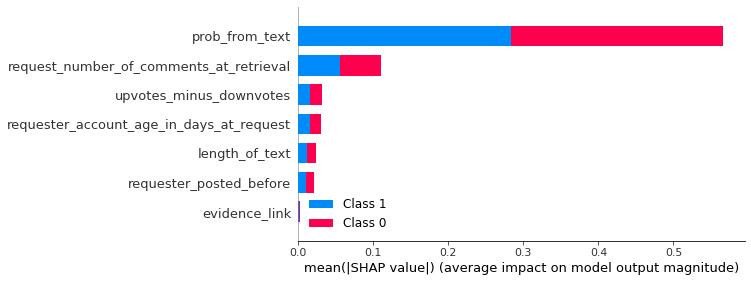

In [46]:
# using shapley values to understand importance of each feature
minmax_word2vec_explainer = shap.TreeExplainer(new_final_minmax_word2vec_model_rf)
minmax_word2vec_shap_values = minmax_word2vec_explainer.shap_values(X_test)
shap.summary_plot(minmax_word2vec_shap_values, X_test, plot_type="bar",show=False)
#plt.savefig('eps/FeatureImportanceShapley_minmax.eps',dpi=1200,bbox_inches='tight')

<BarContainer object of 7 artists>

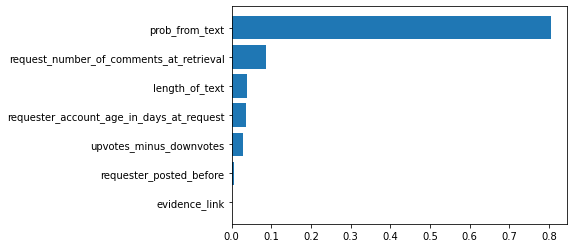

In [47]:
sorted_idx = new_final_minmax_word2vec_model_rf.feature_importances_.argsort()
plt.barh(new_final_minmax_word2vec_rf_df.columns[sorted_idx], new_final_minmax_word2vec_model_rf.feature_importances_[sorted_idx])

In [48]:
test_minmax_word2vec_emb = test_set.apply(lambda r: get_sent_vec_min_max(r['final_request_text']), axis=1)
test_minmax_v = np.column_stack([test_minmax_word2vec_emb.values.tolist()])
test_minmax_word2vec_df = pd.DataFrame(test_minmax_v)
test_minmax_word2vec_labels = test_set['requester_received_pizza']
test_minmax_word2vec_df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,-0.511719,-0.229492,-0.271484,-0.204102,-0.371094,-0.263672,-0.259766,-0.347656,-0.199219,-0.246094,...,0.433594,0.392578,0.292969,0.277344,0.546875,0.488281,0.185547,0.337891,0.523438,0.306641
1,-0.291016,-0.279297,-0.269531,-0.119141,-0.231445,-0.251953,-0.241211,-0.300781,-0.159180,-0.150391,...,0.273438,0.304688,0.043945,0.347656,0.546875,0.326172,0.125000,0.291016,0.324219,0.158203
2,-0.363281,-0.213867,-0.166016,-0.092285,-0.147461,-0.226562,-0.165039,-0.376953,-0.255859,-0.129883,...,0.230469,0.578125,0.143555,0.398438,0.546875,0.187500,0.149414,0.291016,0.242188,0.213867
3,-0.480469,-0.351562,-0.349609,-0.425781,-0.322266,-0.369141,-0.257812,-0.476562,-0.255859,-0.116211,...,0.197266,0.539062,0.231445,0.314453,0.382812,0.190430,0.192383,0.159180,0.320312,0.351562
4,-0.400391,-0.511719,-0.371094,-0.359375,-0.316406,-0.349609,-0.294922,-0.593750,-0.386719,-0.347656,...,0.314453,0.460938,0.296875,0.337891,0.546875,0.314453,0.265625,0.464844,0.308594,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,-0.285156,0.000000,-0.265625,-0.049805,-0.172852,-0.109863,-0.115234,-0.275391,-0.089355,-0.116211,...,0.178711,0.128906,0.043945,0.149414,0.546875,0.187500,0.281250,0.193359,0.228516,0.088867
1130,-0.365234,-0.263672,-0.371094,-0.166016,-0.339844,-0.347656,-0.304688,-0.333984,-0.159180,-0.291016,...,0.246094,0.380859,0.207031,0.441406,0.546875,0.378906,0.324219,0.306641,0.223633,0.300781
1131,-0.455078,-0.242188,-0.333984,-0.092285,-0.250000,-0.226562,-0.289062,-0.314453,-0.149414,-0.116211,...,0.314453,0.296875,0.238281,0.419922,0.546875,0.182617,0.355469,0.335938,0.200195,0.339844
1132,-0.253906,-0.351562,-0.125000,-0.159180,-0.283203,-0.251953,-0.235352,-0.281250,-0.154297,-0.116211,...,0.246094,0.310547,0.207031,0.263672,0.546875,0.187500,0.159180,0.072754,0.209961,0.188477


In [49]:
test_final_minmax_word2vec_rf_df = final_test_set.copy()
test_tfidf_minmax_word2vec_est_prob = new_minmax_word2vec_model_rf.predict_proba(test_minmax_word2vec_df)[:,1]
test_final_minmax_word2vec_rf_df.insert(5,'prob_from_text',test_tfidf_minmax_word2vec_est_prob)
test_final_minmax_word2vec_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,32,101.674711,7,544,0,0.256780,0,0
1,0,375.440579,0,418,0,0.222599,1,1
2,4,256.866597,2,284,0,0.205932,0,0
3,-1,658.583252,0,508,0,0.302825,0,0
4,7,107.608137,9,1234,0,0.435876,0,1
...,...,...,...,...,...,...,...,...
1129,4,4.233056,0,134,0,0.214689,0,0
1130,1,3.019410,0,545,0,0.291808,0,0
1131,5,505.021308,0,235,0,0.155085,0,0
1132,2,319.033148,0,242,0,0.102542,0,0


In [50]:
test_final_minmax_word2vec_rf_df = test_final_minmax_word2vec_rf_df.sample(frac=1).reset_index(drop=True)
test_final_minmax_word2vec_rf_labels = test_final_minmax_word2vec_rf_df.iloc[:,-1]
test_final_minmax_word2vec_rf_df = test_final_minmax_word2vec_rf_df.iloc[:,:-1]
test_final_minmax_word2vec_rf_labels

0       0
1       0
2       0
3       1
4       0
       ..
1129    0
1130    1
1131    1
1132    0
1133    0
Name: requester_received_pizza, Length: 1134, dtype: int64

In [51]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)), precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)), recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)), precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)), recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)), f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df))],
    ['Random Forest', accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df)), precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df)), recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df)), f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.6419753086419753,0.34901960784313724,0.7063492063492064,0.46719160104986873
Gaussian NB,0.7548500881834215,0.4166666666666667,0.25793650793650796,0.3186274509803922
Random Forest,0.7680776014109347,0.4666666666666667,0.3055555555555556,0.3693045563549161


## Random Forest based Doc2Vec 100 Model

In [52]:
new_tagged_data = [TaggedDocument(words=process_text(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train_set['final_request_text'])]

new_doc2vec_100_model = Doc2Vec(vector_size=100, min_count=2, epochs = 50)

new_doc2vec_100_model.build_vocab(new_tagged_data)
new_doc2vec_100_model.train(new_tagged_data, epochs=new_doc2vec_100_model.epochs, total_examples=new_doc2vec_100_model.corpus_count)

new_doc2vec_100_v = np.row_stack([new_doc2vec_100_model.infer_vector(process_text(train_set['final_request_text'][x])) for x in range(len(train_set))])
new_doc2vec_100_df = pd.DataFrame(new_doc2vec_100_v)
new_doc2vec_100_labels = train_set['requester_received_pizza']

# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_doc2vec_100 = StratifiedKFold(n_splits = 5, shuffle=True, random_state=RANDOM_STATE)
new_doc2vec_100_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_doc2vec_100_model_nbg = GaussianNB()
new_doc2vec_100_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_doc2vec_100_model_lr_accuracy_score = []
new_doc2vec_100_model_nbg_accuracy_score = []
new_doc2vec_100_model_rf_accuracy_score = []

for train_index, test_index in new_skfold_doc2vec_100.split(new_doc2vec_100_df, new_doc2vec_100_labels):
    X_train, X_test = new_doc2vec_100_df.iloc[train_index,:], new_doc2vec_100_df.iloc[test_index,:]
    y_train, y_test = new_doc2vec_100_labels[train_index], new_doc2vec_100_labels[test_index]
    
    new_doc2vec_100_model_lr.fit(X_train,y_train)
    new_doc2vec_100_model_lr_accuracy_score.append(accuracy_score(y_test,new_doc2vec_100_model_lr.predict(X_test)))
    
    new_doc2vec_100_model_nbg.fit(X_train,y_train)
    new_doc2vec_100_model_nbg_accuracy_score.append(accuracy_score(y_test,new_doc2vec_100_model_nbg.predict(X_test)))
    
    new_doc2vec_100_model_rf.fit(X_train,y_train)
    new_doc2vec_100_model_rf_accuracy_score.append(accuracy_score(y_test,new_doc2vec_100_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy']
t.add_rows([
    ['Logistic Regression', mean(new_doc2vec_100_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_doc2vec_100_model_nbg_accuracy_score)],
    ['Random Forest', mean(new_doc2vec_100_model_rf_accuracy_score)]
])
t

Model,Accuracy
Logistic Regression,0.38682129691241396
Gaussian NB,0.6475651928952008
Random Forest,0.7463089334544342


In [53]:
new_final_doc2vec_100_rf_df = final_train_set.copy()
new_doc2vec_100_rf_est_prob = new_doc2vec_100_model_rf.predict_proba(new_doc2vec_100_df)[:,1]
new_final_doc2vec_100_rf_df.insert(5,'prob_from_text',new_doc2vec_100_rf_est_prob)

In [54]:
new_final_doc2vec_100_rf_df = new_final_doc2vec_100_rf_df.sample(frac=1).reset_index(drop=True)
new_final_doc2vec_100_rf_labels = new_final_doc2vec_100_rf_df.iloc[:,-1]
new_final_doc2vec_100_rf_df = new_final_doc2vec_100_rf_df.iloc[:,:-1]
new_final_doc2vec_100_rf_labels

0       0
1       0
2       0
3       1
4       0
       ..
4532    0
4533    0
4534    0
4535    0
4536    1
Name: requester_received_pizza, Length: 4537, dtype: int64

In [55]:
new_skfold_final_doc2vec_100 = StratifiedKFold(n_splits = 5,shuffle=True, random_state=RANDOM_STATE)
new_final_doc2vec_100_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_final_doc2vec_100_model_nbg = GaussianNB()
new_final_doc2vec_100_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_final_doc2vec_100_model_lr_accuracy_score = []
new_final_doc2vec_100_model_nbg_accuracy_score = []
new_final_doc2vec_100_model_rf_accuracy_score = []

new_final_doc2vec_100_model_lr_precision_score = []
new_final_doc2vec_100_model_nbg_precision_score = []
new_final_doc2vec_100_model_rf_precision_score = []

new_final_doc2vec_100_model_lr_recall_score = []
new_final_doc2vec_100_model_nbg_recall_score = []
new_final_doc2vec_100_model_rf_recall_score = []

new_final_doc2vec_100_model_lr_f1_score = []
new_final_doc2vec_100_model_nbg_f1_score = []
new_final_doc2vec_100_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_doc2vec_100.split(new_final_doc2vec_100_rf_df, new_final_doc2vec_100_rf_labels):
    X_train, X_test = new_final_doc2vec_100_rf_df.iloc[train_index,:], new_final_doc2vec_100_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_doc2vec_100_rf_labels[train_index], new_final_doc2vec_100_rf_labels[test_index]
    
    new_final_doc2vec_100_model_lr.fit(X_train,y_train)
    new_final_doc2vec_100_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_100_model_lr.predict(X_test)))
    new_final_doc2vec_100_model_lr_precision_score.append(precision_score(y_test,new_final_doc2vec_100_model_lr.predict(X_test)))
    new_final_doc2vec_100_model_lr_recall_score.append(recall_score(y_test,new_final_doc2vec_100_model_lr.predict(X_test)))
    new_final_doc2vec_100_model_lr_f1_score.append(f1_score(y_test,new_final_doc2vec_100_model_lr.predict(X_test)))
    
    new_final_doc2vec_100_model_nbg.fit(X_train,y_train)
    new_final_doc2vec_100_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_100_model_nbg.predict(X_test)))
    new_final_doc2vec_100_model_nbg_precision_score.append(precision_score(y_test,new_final_doc2vec_100_model_nbg.predict(X_test)))
    new_final_doc2vec_100_model_nbg_recall_score.append(recall_score(y_test,new_final_doc2vec_100_model_nbg.predict(X_test)))
    new_final_doc2vec_100_model_nbg_f1_score.append(f1_score(y_test,new_final_doc2vec_100_model_nbg.predict(X_test)))

    new_final_doc2vec_100_model_rf.fit(X_train,y_train)
    new_final_doc2vec_100_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_100_model_rf.predict(X_test)))
    new_final_doc2vec_100_model_rf_precision_score.append(precision_score(y_test,new_final_doc2vec_100_model_rf.predict(X_test)))
    new_final_doc2vec_100_model_rf_recall_score.append(recall_score(y_test,new_final_doc2vec_100_model_rf.predict(X_test)))
    new_final_doc2vec_100_model_rf_f1_score.append(f1_score(y_test,new_final_doc2vec_100_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(new_final_doc2vec_100_model_lr_accuracy_score),mean(new_final_doc2vec_100_model_lr_precision_score),mean(new_final_doc2vec_100_model_lr_recall_score),mean(new_final_doc2vec_100_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_doc2vec_100_model_nbg_accuracy_score),mean(new_final_doc2vec_100_model_nbg_precision_score),mean(new_final_doc2vec_100_model_nbg_recall_score),mean(new_final_doc2vec_100_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_doc2vec_100_model_rf_accuracy_score),mean(new_final_doc2vec_100_model_rf_precision_score),mean(new_final_doc2vec_100_model_rf_recall_score),mean(new_final_doc2vec_100_model_rf_f1_score)],
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.9199937830578613,0.7863724192224649,0.9388646288209607,0.8556558282995202
Gaussian NB,0.932774941837592,0.8667306941719142,0.8672489082969432,0.8668617729258007
Random Forest,0.9493052081461371,0.9315917503174964,0.862882096069869,0.8957319031805333


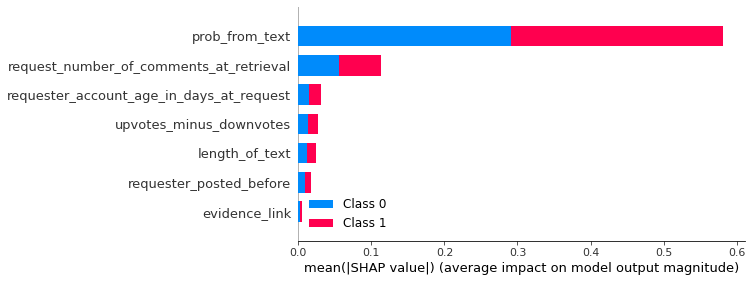

In [56]:
# using shapley values to understand importance of each feature
doc2vec_100_explainer = shap.TreeExplainer(new_final_doc2vec_100_model_rf)
doc2vec_100_shap_values = doc2vec_100_explainer.shap_values(X_test)
shap.summary_plot(doc2vec_100_shap_values, X_test, plot_type="bar")
#plt.savefig('eps/FeatureImportanceShapley_doc2vec_100.eps',dpi=1200,bbox_inches='tight')

<BarContainer object of 7 artists>

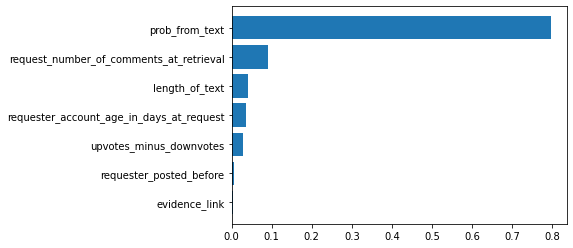

In [57]:
sorted_idx = new_final_doc2vec_100_model_rf.feature_importances_.argsort()
plt.barh(new_final_doc2vec_100_rf_df.columns[sorted_idx], new_final_doc2vec_100_model_rf.feature_importances_[sorted_idx])

In [58]:
test_doc2vec_100_v = np.row_stack([new_doc2vec_100_model.infer_vector(process_text(test_set['final_request_text'][x])) for x in range(len(test_set))])
test_doc2vec_100_df = pd.DataFrame(test_doc2vec_100_v)

In [59]:
test_final_doc2vec_100_rf_df = final_test_set.copy()
test_tfidf_doc2vec_100_est_prob = new_doc2vec_100_model_rf.predict_proba(test_doc2vec_100_df)[:,1]
test_final_doc2vec_100_rf_df.insert(5,'prob_from_text',test_tfidf_doc2vec_100_est_prob)
test_final_doc2vec_100_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,32,101.674711,7,544,0,0.370904,0,0
1,0,375.440579,0,418,0,0.364407,1,1
2,4,256.866597,2,284,0,0.372316,0,0
3,-1,658.583252,0,508,0,0.339548,0,0
4,7,107.608137,9,1234,0,0.495198,0,1
...,...,...,...,...,...,...,...,...
1129,4,4.233056,0,134,0,0.123164,0,0
1130,1,3.019410,0,545,0,0.454802,0,0
1131,5,505.021308,0,235,0,0.221469,0,0
1132,2,319.033148,0,242,0,0.293503,0,0


In [60]:
test_final_doc2vec_100_rf_df = test_final_doc2vec_100_rf_df.sample(frac=1).reset_index(drop=True)
test_final_doc2vec_100_rf_labels = test_final_doc2vec_100_rf_df.iloc[:,-1]
test_final_doc2vec_100_rf_df = test_final_doc2vec_100_rf_df.iloc[:,:-1]
test_final_doc2vec_100_rf_labels

0       0
1       0
2       1
3       0
4       1
       ..
1129    0
1130    1
1131    0
1132    0
1133    1
Name: requester_received_pizza, Length: 1134, dtype: int64

In [61]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)), precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)), recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)), precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)), recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)), f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df))],
    ['Random Forest', accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df)), precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df)), recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df)), f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.41798941798941797,0.25943396226415094,0.873015873015873,0.39999999999999997
Gaussian NB,0.6375661375661376,0.31724137931034485,0.5476190476190477,0.4017467248908298
Random Forest,0.7513227513227513,0.44047619047619047,0.44047619047619047,0.44047619047619047


## Random Forest based Doc2Vec 300 Model

In [62]:
new_tagged_data = [TaggedDocument(words=process_text(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train_set['final_request_text'])]

new_doc2vec_300_model = Doc2Vec(vector_size=300, min_count=2, epochs = 50)

new_doc2vec_300_model.build_vocab(new_tagged_data)
new_doc2vec_300_model.train(new_tagged_data, epochs=new_doc2vec_300_model.epochs, total_examples=new_doc2vec_300_model.corpus_count)

new_doc2vec_300_v = np.row_stack([new_doc2vec_300_model.infer_vector(process_text(train_set['final_request_text'][x])) for x in range(len(train_set))])
new_doc2vec_300_df = pd.DataFrame(new_doc2vec_300_v)
new_doc2vec_300_labels = train_set['requester_received_pizza']

# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_doc2vec_300 = StratifiedKFold(n_splits = 5, shuffle=True, random_state=RANDOM_STATE)
new_doc2vec_300_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_doc2vec_300_model_nbg = GaussianNB()
new_doc2vec_300_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_doc2vec_300_model_lr_accuracy_score = []
new_doc2vec_300_model_nbg_accuracy_score = []
new_doc2vec_300_model_rf_accuracy_score = []

for train_index, test_index in new_skfold_doc2vec_300.split(new_doc2vec_300_df, new_doc2vec_300_labels):
    X_train, X_test = new_doc2vec_300_df.iloc[train_index,:], new_doc2vec_300_df.iloc[test_index,:]
    y_train, y_test = new_doc2vec_300_labels[train_index], new_doc2vec_300_labels[test_index]
    
    new_doc2vec_300_model_lr.fit(X_train,y_train)
    new_doc2vec_300_model_lr_accuracy_score.append(accuracy_score(y_test,new_doc2vec_300_model_lr.predict(X_test)))
    
    new_doc2vec_300_model_nbg.fit(X_train,y_train)
    new_doc2vec_300_model_nbg_accuracy_score.append(accuracy_score(y_test,new_doc2vec_300_model_nbg.predict(X_test)))
    
    new_doc2vec_300_model_rf.fit(X_train,y_train)
    new_doc2vec_300_model_rf_accuracy_score.append(accuracy_score(y_test,new_doc2vec_300_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy']
t.add_rows([
    ['Logistic Regression', mean(new_doc2vec_300_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_doc2vec_300_model_nbg_accuracy_score)],
    ['Random Forest', mean(new_doc2vec_300_model_rf_accuracy_score)]
])
t

Model,Accuracy
Logistic Regression,0.45911583426020813
Gaussian NB,0.6345603699080573
Random Forest,0.7465287120730102


In [63]:
new_final_doc2vec_300_rf_df = final_train_set.copy()
new_doc2vec_300_rf_est_prob = new_doc2vec_300_model_rf.predict_proba(new_doc2vec_300_df)[:,1]
new_final_doc2vec_300_rf_df.insert(5,'prob_from_text',new_doc2vec_300_rf_est_prob)

In [64]:
new_final_doc2vec_300_rf_df = new_final_doc2vec_300_rf_df.sample(frac=1).reset_index(drop=True)
new_final_doc2vec_300_rf_labels = new_final_doc2vec_300_rf_df.iloc[:,-1]
new_final_doc2vec_300_rf_df = new_final_doc2vec_300_rf_df.iloc[:,:-1]
new_final_doc2vec_300_rf_labels

0       1
1       0
2       1
3       0
4       0
       ..
4532    0
4533    1
4534    0
4535    0
4536    0
Name: requester_received_pizza, Length: 4537, dtype: int64

In [65]:
new_skfold_final_doc2vec_300 = StratifiedKFold(n_splits = 5, shuffle=True, random_state=RANDOM_STATE)
new_final_doc2vec_300_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_final_doc2vec_300_model_nbg = GaussianNB()
new_final_doc2vec_300_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_final_doc2vec_300_model_lr_accuracy_score = []
new_final_doc2vec_300_model_nbg_accuracy_score = []
new_final_doc2vec_300_model_rf_accuracy_score = []

new_final_doc2vec_300_model_lr_precision_score = []
new_final_doc2vec_300_model_nbg_precision_score = []
new_final_doc2vec_300_model_rf_precision_score = []

new_final_doc2vec_300_model_lr_recall_score = []
new_final_doc2vec_300_model_nbg_recall_score = []
new_final_doc2vec_300_model_rf_recall_score = []

new_final_doc2vec_300_model_lr_f1_score = []
new_final_doc2vec_300_model_nbg_f1_score = []
new_final_doc2vec_300_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_doc2vec_300.split(new_final_doc2vec_300_rf_df, new_final_doc2vec_300_rf_labels):
    X_train, X_test = new_final_doc2vec_300_rf_df.iloc[train_index,:], new_final_doc2vec_300_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_doc2vec_300_rf_labels[train_index], new_final_doc2vec_300_rf_labels[test_index]
    
    new_final_doc2vec_300_model_lr.fit(X_train,y_train)
    new_final_doc2vec_300_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_300_model_lr.predict(X_test)))
    new_final_doc2vec_300_model_lr_precision_score.append(precision_score(y_test,new_final_doc2vec_300_model_lr.predict(X_test)))
    new_final_doc2vec_300_model_lr_recall_score.append(recall_score(y_test,new_final_doc2vec_300_model_lr.predict(X_test)))
    new_final_doc2vec_300_model_lr_f1_score.append(f1_score(y_test,new_final_doc2vec_300_model_lr.predict(X_test)))
    
    new_final_doc2vec_300_model_nbg.fit(X_train,y_train)
    new_final_doc2vec_300_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_300_model_nbg.predict(X_test)))
    new_final_doc2vec_300_model_nbg_precision_score.append(precision_score(y_test,new_final_doc2vec_300_model_nbg.predict(X_test)))
    new_final_doc2vec_300_model_nbg_recall_score.append(recall_score(y_test,new_final_doc2vec_300_model_nbg.predict(X_test)))
    new_final_doc2vec_300_model_nbg_f1_score.append(f1_score(y_test,new_final_doc2vec_300_model_nbg.predict(X_test)))

    new_final_doc2vec_300_model_rf.fit(X_train,y_train)
    new_final_doc2vec_300_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_300_model_rf.predict(X_test)))
    new_final_doc2vec_300_model_rf_precision_score.append(precision_score(y_test,new_final_doc2vec_300_model_rf.predict(X_test)))
    new_final_doc2vec_300_model_rf_recall_score.append(recall_score(y_test,new_final_doc2vec_300_model_rf.predict(X_test)))
    new_final_doc2vec_300_model_rf_f1_score.append(f1_score(y_test,new_final_doc2vec_300_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(new_final_doc2vec_300_model_lr_accuracy_score),mean(new_final_doc2vec_300_model_lr_precision_score),mean(new_final_doc2vec_300_model_lr_recall_score),mean(new_final_doc2vec_300_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_doc2vec_300_model_nbg_accuracy_score),mean(new_final_doc2vec_300_model_nbg_precision_score),mean(new_final_doc2vec_300_model_nbg_recall_score),mean(new_final_doc2vec_300_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_doc2vec_300_model_rf_accuracy_score),mean(new_final_doc2vec_300_model_rf_precision_score),mean(new_final_doc2vec_300_model_rf_recall_score),mean(new_final_doc2vec_300_model_rf_f1_score)],
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.9188878473352147,0.7844593121530052,0.9362445414847161,0.8535677990558015
Gaussian NB,0.9343187348522748,0.8713719643116565,0.868122270742358,0.8696278771457112
Random Forest,0.9493061795433462,0.9337734652393296,0.8602620087336245,0.8954249554064325


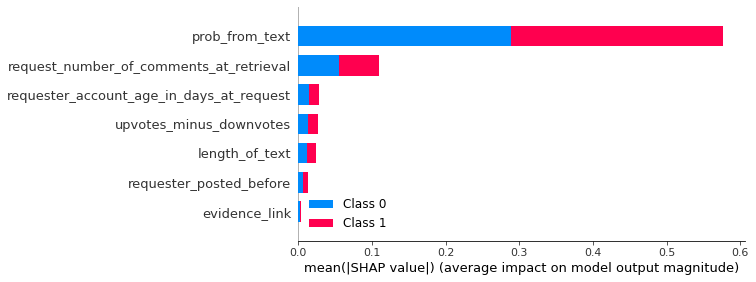

In [66]:
# using shapley values to understand importance of each feature
doc2vec_300_explainer = shap.TreeExplainer(new_final_doc2vec_300_model_rf)
doc2vec_300_shap_values = doc2vec_300_explainer.shap_values(X_test)
shap.summary_plot(doc2vec_300_shap_values, X_test, plot_type="bar")
#plt.savefig('eps/FeatureImportanceShapley_doc2vec_300.eps',dpi=1200,bbox_inches='tight')

<BarContainer object of 7 artists>

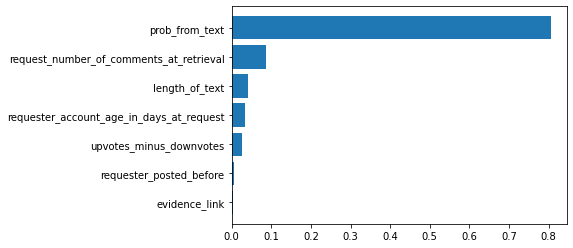

In [67]:
sorted_idx = new_final_doc2vec_300_model_rf.feature_importances_.argsort()
plt.barh(new_final_doc2vec_300_rf_df.columns[sorted_idx], new_final_doc2vec_300_model_rf.feature_importances_[sorted_idx])

In [68]:
test_doc2vec_300_v = np.row_stack([new_doc2vec_300_model.infer_vector(process_text(test_set['final_request_text'][x])) for x in range(len(test_set))])
test_doc2vec_300_df = pd.DataFrame(test_doc2vec_300_v)

In [69]:
test_final_doc2vec_300_rf_df = final_test_set.copy()
test_tfidf_doc2vec_300_est_prob = new_doc2vec_300_model_rf.predict_proba(test_doc2vec_300_df)[:,1]
test_final_doc2vec_300_rf_df.insert(5,'prob_from_text',test_tfidf_doc2vec_300_est_prob)
test_final_doc2vec_300_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,32,101.674711,7,544,0,0.414972,0,0
1,0,375.440579,0,418,0,0.368079,1,1
2,4,256.866597,2,284,0,0.416102,0,0
3,-1,658.583252,0,508,0,0.355650,0,0
4,7,107.608137,9,1234,0,0.473446,0,1
...,...,...,...,...,...,...,...,...
1129,4,4.233056,0,134,0,0.095763,0,0
1130,1,3.019410,0,545,0,0.410169,0,0
1131,5,505.021308,0,235,0,0.270056,0,0
1132,2,319.033148,0,242,0,0.323446,0,0


In [70]:
test_final_doc2vec_300_rf_df = test_final_doc2vec_300_rf_df.sample(frac=1).reset_index(drop=True)
test_final_doc2vec_300_rf_labels = test_final_doc2vec_300_rf_df.iloc[:,-1]
test_final_doc2vec_300_rf_df = test_final_doc2vec_300_rf_df.iloc[:,:-1]
test_final_doc2vec_300_rf_labels

0       0
1       0
2       1
3       0
4       0
       ..
1129    0
1130    0
1131    0
1132    0
1133    0
Name: requester_received_pizza, Length: 1134, dtype: int64

In [71]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)), precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)), recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)), precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)), recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)), f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df))],
    ['Random Forest', accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df)), precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df)), recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df)), f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.3844797178130511,0.25277161862527714,0.9047619047619048,0.39514731369150774
Gaussian NB,0.6005291005291006,0.2977867203219316,0.5873015873015873,0.3951935914552737
Random Forest,0.7407407407407407,0.42905405405405406,0.503968253968254,0.4635036496350365


In [72]:
# testing performance

final_accuracy = pd.DataFrame({'Count Model':[
                             100*accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)),
                             100*accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)),
                             100*accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))
                         ], 
                         'TF-IDF':[
                             100*accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),
                             100*accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)),
                             100*accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))
                         ], 
                         'Min-Max Doc2Vec':[
                             100*accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),
                             100*accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)),
                             100*accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))
                         ],
                         'Doc2Vec 100':[
                             100*accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),
                             100*accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)),
                             100*accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))
                         ],
                         'Doc2Vec 300':[
                             100*accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),
                             100*accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)),
                             100*accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])
final_precision = pd.DataFrame({'Count Model':[
                             100*precision_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)),
                             100*precision_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)),
                             100*precision_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))
                         ], 
                         'TF-IDF':[
                             100*precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),
                             100*precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)),
                             100*precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))
                         ], 
                         'Min-Max Doc2Vec':[
                             100*precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),
                             100*precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)),
                             100*precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))
                         ],
                         'Doc2Vec 100':[
                             100*precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),
                             100*precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)),
                             100*precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))
                         ],
                         'Doc2Vec 300':[
                             100*precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),
                             100*precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)),
                             100*precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])

final_recall = pd.DataFrame({'Count Model':[
                             100*recall_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)),
                             100*recall_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)),
                             100*recall_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))
                         ], 
                         'TF-IDF':[
                             100*recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),
                             100*recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)),
                             100*recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))
                         ], 
                         'Min-Max Doc2Vec':[
                             100*recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),
                             100*recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)),
                             100*recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))
                         ],
                         'Doc2Vec 100':[
                             100*recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),
                             100*recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)),
                             100*recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))
                         ],
                         'Doc2Vec 300':[
                             100*recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),
                             100*recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)),
                             100*recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])
final_f1_score = pd.DataFrame({'Count Model':[
                             100*f1_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)),
                             100*f1_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)),
                             100*f1_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))
                         ], 
                         'TF-IDF':[
                             100*f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),
                             100*f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)),
                             100*f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))
                         ], 
                         'Min-Max Doc2Vec':[
                             100*f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),
                             100*f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)),
                             100*f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))
                         ],
                         'Doc2Vec 100':[
                             100*f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),
                             100*f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)),
                             100*f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))
                         ],
                         'Doc2Vec 300':[
                             100*f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),
                             100*f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)),
                             100*f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])

final_auc_roc = pd.DataFrame({'Count Model':[
                             100*roc_auc_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict_proba(test_final_count_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict_proba(test_final_count_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict_proba(test_final_count_rf_df)[:, 1])
                         ], 
                         'TF-IDF':[
                             100*roc_auc_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict_proba(test_final_tfidf_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict_proba(test_final_tfidf_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict_proba(test_final_tfidf_rf_df)[:, 1])
                         ],
                         'Min-Max Doc2Vec':[
                             100*roc_auc_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict_proba(test_final_minmax_word2vec_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict_proba(test_final_minmax_word2vec_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict_proba(test_final_minmax_word2vec_rf_df)[:, 1])
                         ],
                         'Doc2Vec 100':[
                             100*roc_auc_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict_proba(test_final_doc2vec_100_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict_proba(test_final_doc2vec_100_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict_proba(test_final_doc2vec_100_rf_df)[:, 1])
                         ],
                         'Doc2Vec 300':[
                             100*roc_auc_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict_proba(test_final_doc2vec_300_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict_proba(test_final_doc2vec_300_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict_proba(test_final_doc2vec_300_rf_df)[:, 1])
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])

final_auc_roc

,Count Model,TF-IDF,Min-Max Doc2Vec,Doc2Vec 100,Doc2Vec 300
LogReg,67.981320,66.267592,70.506245,66.120469,65.416802
Gaussian NB,68.445182,67.103535,67.985369,64.437786,64.083702
RF,73.478836,72.912392,76.783915,76.571105,75.892182


In [73]:
final_accuracy

,Count Model,TF-IDF,Min-Max Doc2Vec,Doc2Vec 100,Doc2Vec 300
LogReg,65.520282,63.403880,64.197531,41.798942,38.447972
Gaussian NB,72.663139,72.134039,75.485009,63.756614,60.052910
RF,76.278660,75.485009,76.807760,75.132275,74.074074


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be

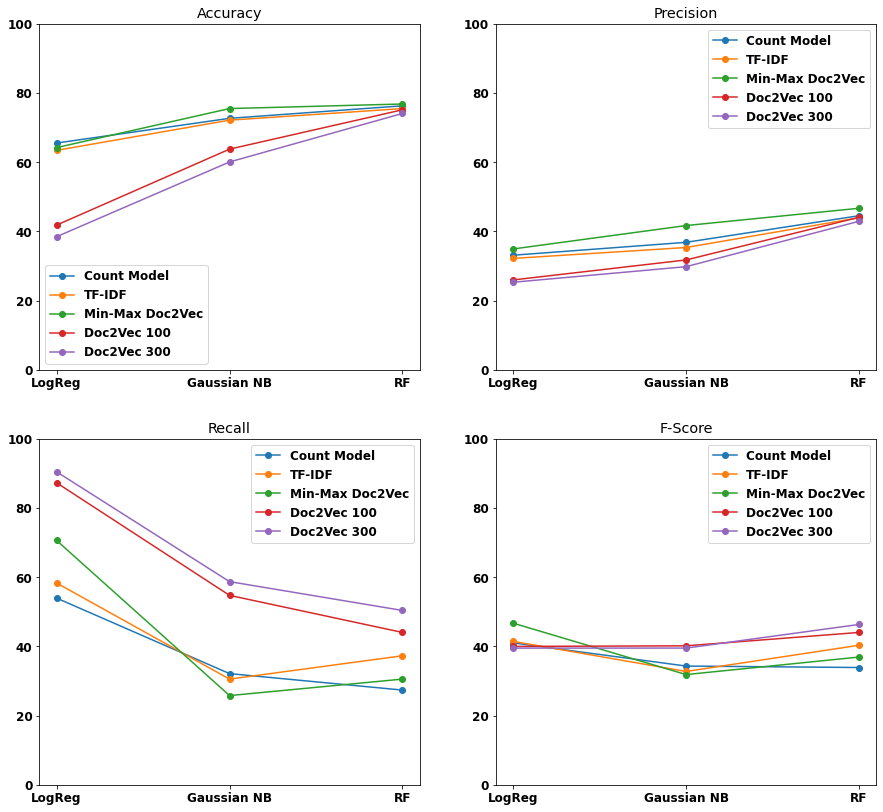

In [74]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
fig, ax = plt.subplots(2,2, figsize=(15,14))
ax[0][0].plot(final_accuracy.index,final_accuracy.loc[final_accuracy.index,:], marker = 'o')
ax[0][0].legend(final_accuracy.columns)
ax[0][0].set_ylim(0,100)
ax[0][0].set_title('Accuracy')
ax[0][1].plot(final_precision.index,final_precision.loc[final_precision.index,:], marker = 'o')
ax[0][1].legend(final_precision.columns)
ax[0][1].set_ylim(0,100)
ax[0][1].set_title('Precision')
ax[1][0].plot(final_recall.index,final_recall.loc[final_recall.index,:], marker = 'o')
ax[1][0].legend(final_recall.columns)
ax[1][0].set_ylim(0,100)
ax[1][0].set_title('Recall')
ax[1][1].plot(final_f1_score.index,final_f1_score.loc[final_f1_score.index,:], marker = 'o')
ax[1][1].legend(final_f1_score.columns)
ax[1][1].set_ylim(0,100)
ax[1][1].set_title('F-Score')
fig.show()
fig.savefig('eps/Final_Model_Performance.eps',dpi=1200, bbox_inches = 'tight')

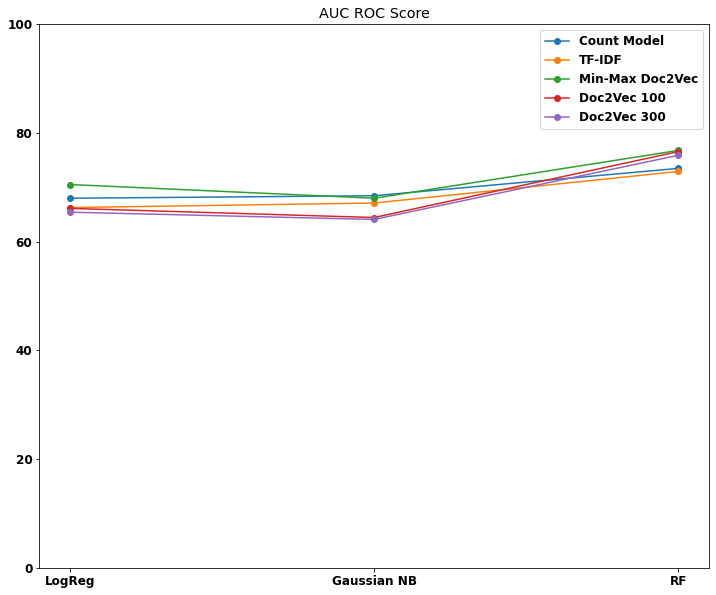

In [75]:
plt.figure(figsize = (12,10))
plt.plot(final_auc_roc.index,final_auc_roc.loc[final_auc_roc.index,:], marker = 'o')
plt.legend(final_auc_roc.columns)
plt.ylim(0,100)
plt.title('AUC ROC Score')
#plt.savefig('eps/Auc_Roc_Score_metric.eps', dpi = 1200, bbox_inches = 'tight')
plt.show()

### Graph for Text Models

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


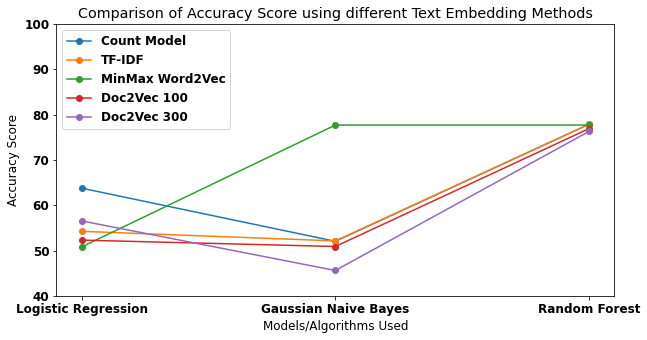

In [76]:
text_accuracy_score = {'Count Model':[accuracy_score(final_test_set['requester_received_pizza'],new_count_model_lr.predict(test_count_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_count_model_nbg.predict(test_count_df.toarray()))*100,accuracy_score(final_test_set['requester_received_pizza'],new_count_model_rf.predict(test_count_df))*100], 
                       'TF-IDF':[accuracy_score(final_test_set['requester_received_pizza'],new_tfidf_model_lr.predict(test_tfidf_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_tfidf_model_nbg.predict(test_tfidf_df.toarray()))*100,accuracy_score(final_test_set['requester_received_pizza'],new_tfidf_model_rf.predict(test_tfidf_df))*100],
                       'MinMax Word2Vec':[accuracy_score(final_test_set['requester_received_pizza'],new_minmax_word2vec_model_lr.predict(test_minmax_word2vec_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_minmax_word2vec_model_rf.predict(test_minmax_word2vec_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_minmax_word2vec_model_rf.predict(test_minmax_word2vec_df))*100],
                       'Doc2Vec 100':[accuracy_score(final_test_set['requester_received_pizza'],new_doc2vec_100_model_lr.predict(test_doc2vec_100_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_doc2vec_100_model_nbg.predict(test_doc2vec_100_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_doc2vec_100_model_rf.predict(test_doc2vec_100_df))*100],
                       'Doc2Vec 300':[accuracy_score(final_test_set['requester_received_pizza'],new_doc2vec_300_model_lr.predict(test_doc2vec_300_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_doc2vec_300_model_nbg.predict(test_doc2vec_300_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_doc2vec_300_model_rf.predict(test_doc2vec_300_df))*100]}
plot_data = pd.DataFrame(text_accuracy_score, index=['Logistic Regression','Gaussian Naive Bayes','Random Forest'])

fig = plt.figure(figsize=(10,5))
plt.plot(plot_data.index,plot_data.loc[plot_data.index,:], marker = 'o')
plt.ylim(40,100)
plt.title('Comparison of Accuracy Score using different Text Embedding Methods')
plt.xlabel('Models/Algorithms Used')
plt.ylabel('Accuracy Score')
plt.legend(plot_data.columns)
#plt.savefig('eps/AccScoreTextModel.eps', dpi=1200,bbox_inches='tight')
plt.show()

In [77]:
final_accuracy

,Count Model,TF-IDF,Min-Max Doc2Vec,Doc2Vec 100,Doc2Vec 300
LogReg,65.520282,63.403880,64.197531,41.798942,38.447972
Gaussian NB,72.663139,72.134039,75.485009,63.756614,60.052910
RF,76.278660,75.485009,76.807760,75.132275,74.074074


In [78]:
final_recall

,Count Model,TF-IDF,Min-Max Doc2Vec,Doc2Vec 100,Doc2Vec 300
LogReg,53.968254,58.333333,70.634921,87.301587,90.476190
Gaussian NB,32.142857,30.555556,25.793651,54.761905,58.730159
RF,27.380952,37.301587,30.555556,44.047619,50.396825


In [79]:
final_precision

,Count Model,TF-IDF,Min-Max Doc2Vec,Doc2Vec 100,Doc2Vec 300
LogReg,33.090024,32.166302,34.901961,25.943396,25.277162
Gaussian NB,36.818182,35.321101,41.666667,31.724138,29.778672
RF,44.516129,43.925234,46.666667,44.047619,42.905405


In [80]:
final_f1_score

,Count Model,TF-IDF,Min-Max Doc2Vec,Doc2Vec 100,Doc2Vec 300
LogReg,41.025641,41.466855,46.719160,40.000000,39.514731
Gaussian NB,34.322034,32.765957,31.862745,40.174672,39.519359
RF,33.906634,40.343348,36.930456,44.047619,46.350365


In [81]:
import pickle

pickle.dump(new_final_count_rf_model_lr, open("models/new_final_count_rf_model_lr.sav", 'wb'))
pickle.dump(new_final_count_rf_model_nbg, open("models/new_final_count_rf_model_nbg.sav", 'wb'))
pickle.dump(new_final_count_rf_model_rf, open("models/new_final_count_rf_model_rf.sav", 'wb'))

pickle.dump(new_final_tfidf_rf_model_lr, open("models/new_final_tfidf_rf_model_lr.sav", 'wb'))
pickle.dump(new_final_tfidf_rf_model_nbg, open("models/new_final_tfidf_rf_model_nbg.sav", 'wb'))
pickle.dump(new_final_tfidf_rf_model_rf, open("models/new_final_tfidf_rf_model_rf.sav", 'wb'))

pickle.dump(new_final_minmax_word2vec_model_lr, open("models/new_final_minmax_word2vec_model_lr.sav", 'wb'))
pickle.dump(new_final_minmax_word2vec_model_nbg, open("models/new_final_minmax_word2vec_model_nbg.sav", 'wb'))
pickle.dump(new_final_minmax_word2vec_model_rf, open("models/new_final_minmax_word2vec_model_rf.sav", 'wb'))

pickle.dump(new_final_doc2vec_100_model_lr, open("models/new_final_doc2vec_100_model_lr.sav", 'wb'))
pickle.dump(new_final_doc2vec_100_model_nbg, open("models/new_final_doc2vec_100_model_nbg.sav", 'wb'))
pickle.dump(new_final_doc2vec_100_model_rf, open("models/new_final_doc2vec_100_model_rf.sav", 'wb'))

pickle.dump(new_final_doc2vec_300_model_lr, open("models/new_final_doc2vec_300_model_lr.sav", 'wb'))
pickle.dump(new_final_doc2vec_300_model_nbg, open("models/new_final_doc2vec_300_model_nbg.sav", 'wb'))
pickle.dump(new_final_doc2vec_300_model_rf, open("models/new_final_doc2vec_300_model_rf.sav", 'wb'))

In [82]:
pickle.dump(new_count_model_lr, open("models/new_count_model_lr.sav", 'wb'))
pickle.dump(new_count_model_nbg, open("models/new_count_model_nbg.sav", 'wb'))
pickle.dump(new_count_model_rf, open("models/new_count_model_rf.sav", 'wb'))

pickle.dump(new_tfidf_model_lr, open("models/new_tfidf_model_lr.sav", 'wb'))
pickle.dump(new_tfidf_model_nbg, open("models/new_tfidf_model_nbg.sav", 'wb'))
pickle.dump(new_tfidf_model_rf, open("models/new_tfidf_model_rf.sav", 'wb'))

pickle.dump(new_minmax_word2vec_model_lr, open("models/new_minmax_word2vec_model_lr.sav", 'wb'))
pickle.dump(new_minmax_word2vec_model_nbg, open("models/new_minmax_word2vec_model_nbg.sav", 'wb'))
pickle.dump(new_minmax_word2vec_model_rf, open("models/new_minmax_word2vec_model_rf.sav", 'wb'))

pickle.dump(new_doc2vec_100_model_lr, open("models/new_doc2vec_100_model_lr.sav", 'wb'))
pickle.dump(new_doc2vec_100_model_nbg, open("models/new_doc2vec_100_model_nbg.sav", 'wb'))
pickle.dump(new_doc2vec_100_model_rf, open("models/new_doc2vec_100_model_rf.sav", 'wb'))

pickle.dump(new_doc2vec_300_model_lr, open("models/new_doc2vec_300_model_lr.sav", 'wb'))
pickle.dump(new_doc2vec_300_model_nbg, open("models/new_doc2vec_300_model_nbg.sav", 'wb'))
pickle.dump(new_doc2vec_300_model_rf, open("models/new_doc2vec_300_model_rf.sav", 'wb'))